In [21]:
import torch
import os
from utils import *
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


def load_model():
    # --- 1. Load Pretrained EfficientNet ---
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)

    num_classes = 5 
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model


def train(model, train_loader, val_loader, preprocess_method):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # --- 6. Training Loop ---
    num_epochs = 5
    val_accs = []
    val_losses = []
    train_accs = []
    train_losses = []


    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # --- 7. Evaluation (optional) ---
        acc, loss, precision, recall, f1 = evaluate(model, val_loader)
        val_accs.append(acc)
        val_losses.append(loss)

        print(f'Val Accuracy: {acc:.4f}')
        print(f'Val Loss: {loss:.4f}')
        print(f'Val Precision: {precision:.4f}')
        print(f'Val Recall: {recall:.4f}')
        print(f'Val F1 Score: {f1:.4f}')
        # Validation

        plot_accuracy_and_loss(train_accs, train_losses, val_accs, val_losses)

    
    if not os.path.exists('efficientNet'):
        os.makedirs('efficientNet')
        
    torch.save(model.state_dict(), f'efficientNet/{preprocess_method.__name__}.pth')


def test(model, test_loader, preprocess_method):
    # model = load_model()

    model.load_state_dict(torch.load(f'efficientNet/{preprocess_method.__name__}.pth'))
    model.eval()

    acc, loss, precision, recall, f1 = evaluate(model, test_loader)

    print(f'Metrics for Aptos Dataset')
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Loss: {loss:.4f}')
    print(f'Test  Precision: {precision:.4f}')
    print(f'Test  Recall: {recall:.4f}')
    print(f'Test  F1 Score: {f1:.4f}')


def main(preprocess_method=None):
    # Load training, validation, and test data
    full_train_balanced, full_val, full_test = load_data()

    # Get data loaders with no extra preprocessing
    train_loader, val_loader, test_loader, test_dataset = get_data_loaders(full_train_balanced, full_val, full_test, 16, preprocess_method)

    # Load efficientNet 
    model = load_model()

    # Train model
    train(model, train_loader, val_loader, preprocess_method)

    # Test model
    test(model, test_loader)


Epoch 1/5
------------------------------


100%|██████████| 1563/1563 [1:25:41<00:00,  3.29s/it]


Train Loss: 1.1954 | Train Acc: 0.5061
Epoch [1/5], Loss: 19.1207


100%|██████████| 243/243 [07:44<00:00,  1.91s/it]


Val Accuracy: 0.5539
Val Loss: 0.9213
Val Precision: 0.7423
Val Recall: 0.5539
Val F1 Score: 0.6106


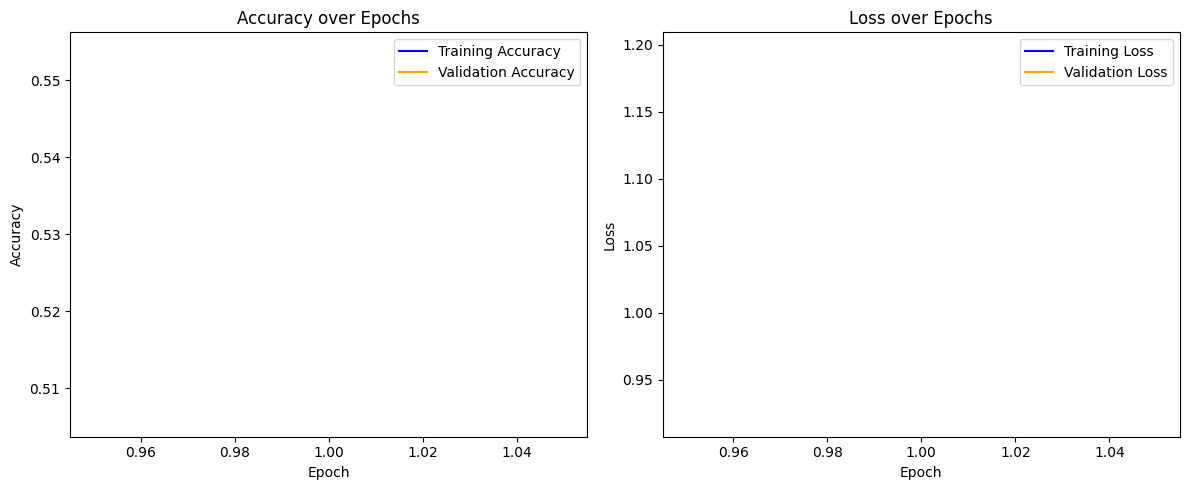

Epoch 2/5
------------------------------


100%|██████████| 1563/1563 [1:09:04<00:00,  2.65s/it]


Train Loss: 0.9313 | Train Acc: 0.6186
Epoch [2/5], Loss: 14.8957


100%|██████████| 243/243 [08:15<00:00,  2.04s/it]


Val Accuracy: 0.6910
Val Loss: 0.7999
Val Precision: 0.7533
Val Recall: 0.6910
Val F1 Score: 0.7132


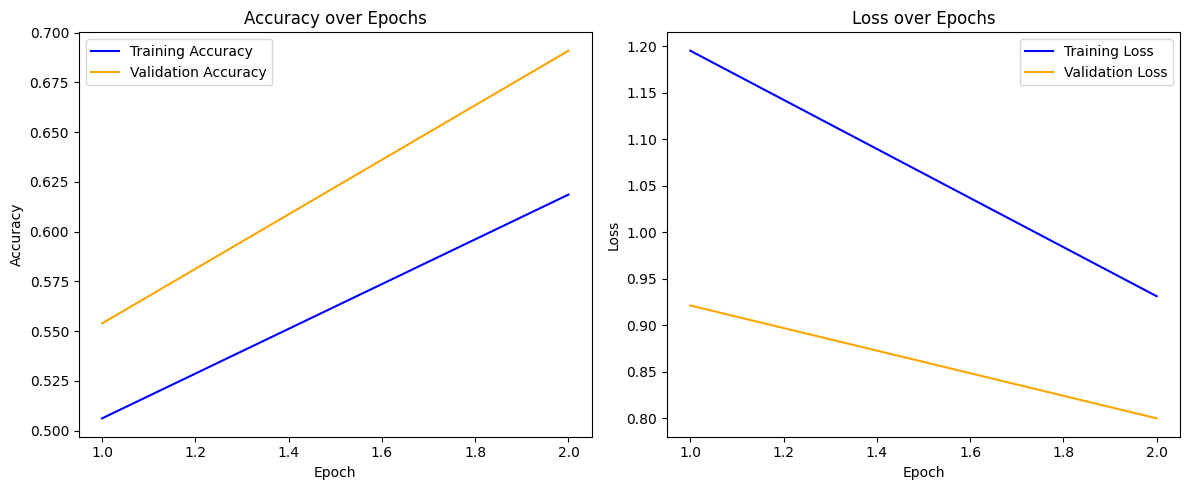

Epoch 3/5
------------------------------


100%|██████████| 1563/1563 [1:08:42<00:00,  2.64s/it]


Train Loss: 0.7785 | Train Acc: 0.6867
Epoch [3/5], Loss: 12.4523


100%|██████████| 243/243 [07:41<00:00,  1.90s/it]


Val Accuracy: 0.6706
Val Loss: 0.8370
Val Precision: 0.7563
Val Recall: 0.6706
Val F1 Score: 0.6973


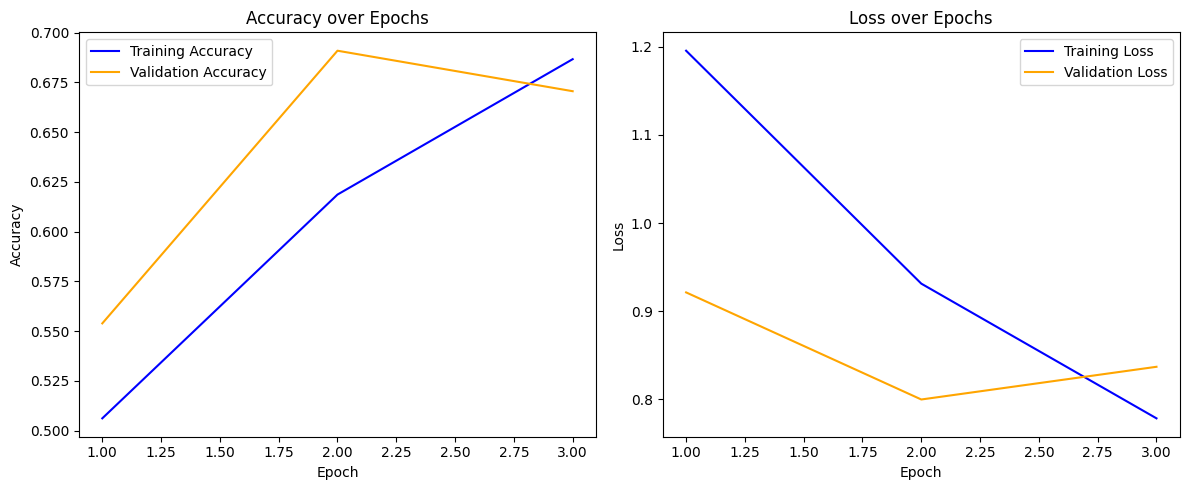

Epoch 4/5
------------------------------


 90%|█████████ | 1410/1563 [1:18:39<09:22,  3.68s/it]

In [22]:
# Train model using different preprocessing methods
main(gaussian_subtractive_normalization)

In [7]:
model.load_state_dict(torch.load('efficientNet/regular.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, test_loader1)
acc2, loss2, precision2, recall2, f12 = evaluate(model, test_loader2)

print(f'Metrics for Aptos Dataset')
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

print(f'Metrics for DR Dataset')
print(f'Test Accuracy: {acc2:.4f}')
print(f'Test Loss: {loss2:.4f}')
print(f'Test  Precision: {precision2:.4f}')
print(f'Test  Recall: {recall2:.4f}')
print(f'Test  F1 Score: {f12:.4f}')

100%|██████████| 440/440 [21:55<00:00,  2.99s/it]

Metrics for Aptos Dataset
Test Accuracy: 0.7722
Test Loss: 0.8601
Test  Precision: 0.7995
Test  Recall: 0.7722
Test  F1 Score: 0.7766
Metrics for DR Dataset
Test Accuracy: 0.6662
Test Loss: 0.8676
Test  Precision: 0.7446
Test  Recall: 0.6662
Test  F1 Score: 0.6952
